In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from utils import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

In [3]:
data_dir = "../Data_Cropped_and_Resized"

### Feature Extraction

In [4]:
train_path = f"{data_dir}/train"

train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units)
_, train_threshold_edges, _ = extract_features(train_path, threshold_image)

In [5]:
valid_path = f"{data_dir}/valid"

valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units)
_, valid_threshold_edges, _ = extract_features(valid_path, threshold_image)

### Dimensionality Reduction (PCA)

In [6]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-', 'r-']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

In [7]:
training_features = [[img.flatten() for img in train_sobel_edges],
            [img.flatten() for img in train_hounsfield_edges],
            [img.flatten() for img in train_threshold_edges]]

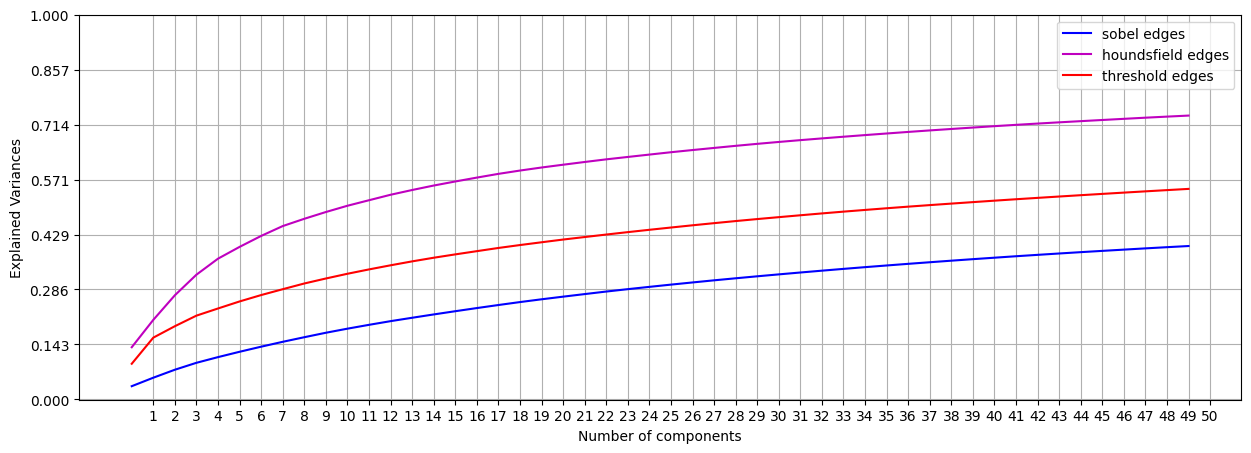

In [8]:
labels = ['sobel edges', 'houndsfield edges', 'threshold edges']

x = plot_PCA(training_features, labels, n_components=50)

In [9]:
# dimensionality reduction

input_features = np.array([[img.flatten() for img in train_sobel_edges],
                            [img.flatten() for img in train_hounsfield_edges],
                            [img.flatten() for img in train_threshold_edges]])

X_sobel_pca, X_hounsfield_pca, X_tresh_pca = get_PCA(input_features, n_components=2)[-1]
X_sobel_tsne, X_hounsfield_tsne, X_thresh_tsne = get_tsne(input_features, n_components=2)


### combined features
combined_train_features = np.array([[np.array([x, y, z]).flatten() for x, y, z in zip(train_sobel_edges, train_hounsfield_edges, train_threshold_edges)]])
X_combined_pca = get_PCA(combined_train_features, n_components=2)[-1][0]
X_combined_tsne = get_tsne(combined_train_features, n_components=2)[0]

combined_val_features = np.array([[np.array([x, y, z]).flatten() for x, y, z in zip(valid_sobel_edges, valid_hounsfield_edges, valid_threshold_edges)]])
X_combined_val_pca = get_PCA(combined_val_features, n_components=2)[-1][0]
X_combined_val_tsne = get_tsne(combined_val_features, n_components=2)[0]

In [20]:
def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in np.unique(y):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

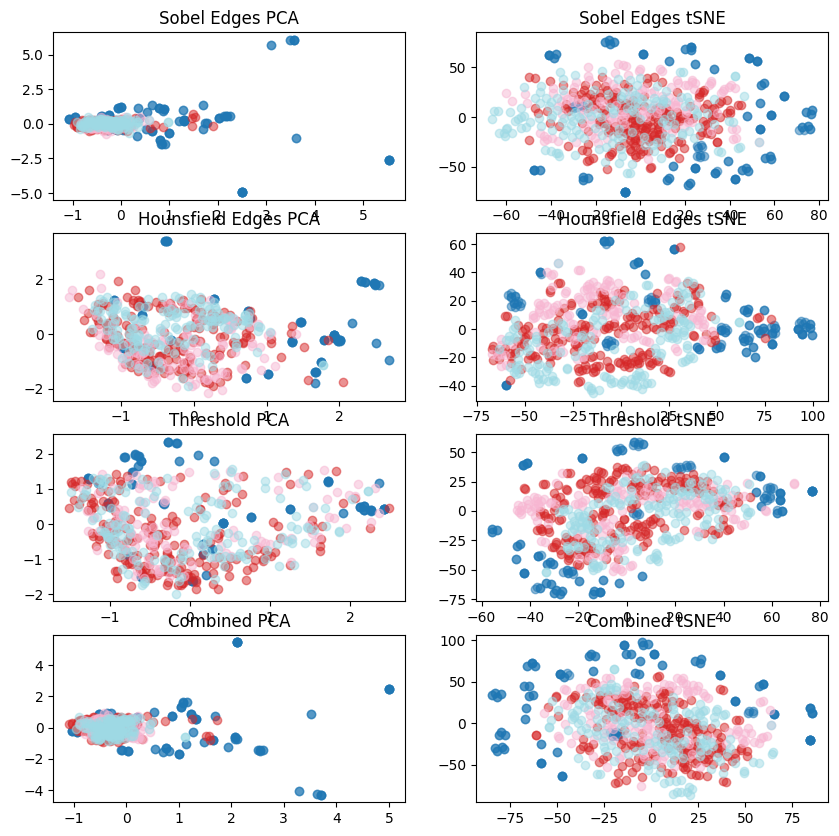

In [30]:
# plot results
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

# y is the class labels
plot_classes(X_sobel_pca, train_labels, ax[0,0], title='Sobel Edges PCA')
plot_classes(X_sobel_tsne, train_labels, ax[0,1], title='Sobel Edges tSNE')

plot_classes(X_hounsfield_pca, train_labels, ax[1,0], title='Hounsfield Edges PCA')
plot_classes(X_hounsfield_tsne, train_labels, ax[1,1], title='Hounsfield Edges tSNE')

plot_classes(X_tresh_pca, train_labels, ax[2,0], title='Threshold PCA')
plot_classes(X_thresh_tsne, train_labels, ax[2,1], title='Threshold tSNE')

plot_classes(X_combined_pca, train_labels, ax[3,0], title='Combined PCA')
plot_classes(X_combined_tsne, train_labels, ax[3,1], title='Combined tSNE')

plt.show()

### SVM

##### Linear SVM

In [38]:
def linear_svm(X_train, y_train, X_val=None, y_val=None):
    clf = SVC(C=1e10, kernel="linear")
    clf.fit(X_train, y_train)
    X_df = pd.DataFrame({"x": X_train[:,0],
                        "y": X_train[:,1],
                        "label": y_train
                        })
    ### plot linear SVM results
    w = clf.coef_[0]
    b = clf.intercept_

    colors = np.random.rand(len(class_mappings.keys()), 3)

    print(f"w = {w}")
    print(f"b = {b}")

    svmx = np.linspace(-2,2)
    svmy = -w[0]/w[1]*svmx - b[0]/w[1]

    fix = plt.figure()
    ax = fig.add_subplot(111)
    for l in class_mappings.keys():
        plt.scatter(X_df[X_df['label'] == l]['x'],
                    X_df[X_df['label'] == l]['y'],
                    c=colors[l], label=class_mappings[l])
        plt.plot(svmx, svmy, "m")
        plt.legend()
        plt.axis([-2, 2, -2, 2])
        plt.show()

In [39]:
linear_svm(X_combined_pca, train_labels)

#### Nonlinear SVM

In [26]:
def nonlinear_svm(X_train, y_train, X_val, y_val):
    clf = SVC(C=1e10, kernel="sigmoid")
    clf.fit(X_train, y_train)

    # Create a mesh grid to plot decision regions
    h = .02  # Step size in the mesh
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain the predicted class labels for each point in the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the decision regions
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Nonlinear SVM Decision Regions')
    plt.show()

    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy:", accuracy)

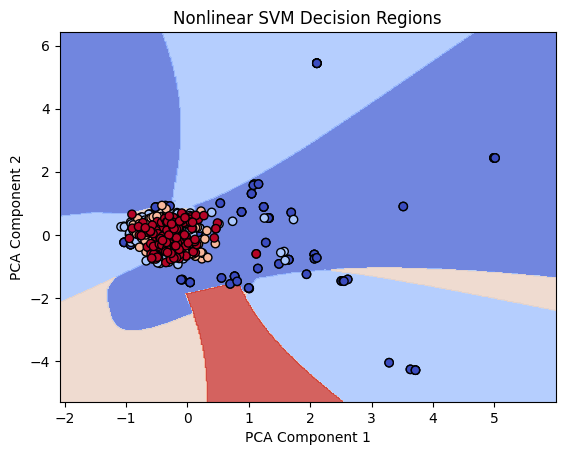

Accuracy: 0.3055555555555556


In [27]:
nonlinear_svm(X_combined_pca, train_labels, X_combined_val_pca, valid_labels)